This is the NLL that takes data from all injectors:

<span style="color: red; font-weight: bold;">Nozzle 1-8 + DS300</span> 



In [64]:
# imports
from __future__ import annotations

from copy import deepcopy
from pathlib import Path
from datetime import datetime
import json
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from standarizer import Standardizer


Here we set our working dir.

In [65]:
PROJECT_ROOT = Path.cwd().resolve() 
DATA_DIR = PROJECT_ROOT / "data_penetration"
RUNS_ROOT = PROJECT_ROOT / "runs_mlp"

PROJECT_ROOT

WindowsPath('C:/Users/Jiang/Documents/Mie_Py/Mie_Postprocessing_Py/MLP')

In [66]:
# Loading the saved CSV files
def load_penetration_dataframe(data_dir: Path) -> pd.DataFrame:
    csv_files = sorted(data_dir.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    frames: list[pd.DataFrame] = []
    for path in csv_files:
        df = pd.read_csv(path)
        df["source_file"] = path.name
        frames.append(df)
    combined = pd.concat(frames, ignore_index=True)
    return combined

Let's try reading the files

In [67]:
raw_df = load_penetration_dataframe(DATA_DIR).dropna().reset_index(drop=True)
print(f"Loaded {len(raw_df)} rows from {raw_df['source_file'].nunique()} files in {DATA_DIR}.")


Loaded 291989 rows from 7 files in C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\MLP\data_penetration.


Let's try seeing its structure

In [68]:
def summarize_numeric(df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return df[numeric_cols].describe().T[["mean", "std", "min", "max"]]

print(summarize_numeric(raw_df).round(3))

                       mean      std      min      max
penetration_pixels  193.708  102.695    0.000  364.000
is_right_censored     0.144    0.351    0.000    1.000
time_ms               1.188    0.385    0.000    1.960
tilt_angle_radian     0.335    0.077    0.140    0.436
plumes               10.407    0.805   10.000   12.000
diameter_mm           0.366    0.013    0.333    0.384
chamber_pressure     10.523    3.704    5.000   15.000
injection_duration  680.710   93.376  500.000  973.500


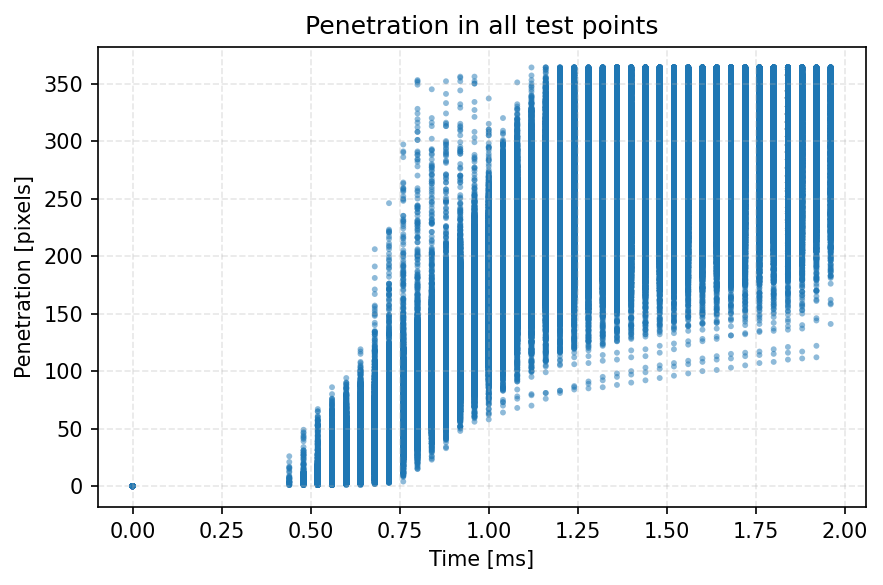

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.scatter(raw_df["time_ms"], raw_df["penetration_pixels"],
s=8, alpha=0.5, edgecolor="none")
ax.set_title("Penetration in all test points")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Penetration [pixels]")
ax.grid(True, linestyle="--", alpha=0.3)
fig.tight_layout()

In [70]:
# Finding all times when penetration pixel <2
times = raw_df.loc[raw_df["penetration_pixels"] < 2, "time_ms"].to_numpy(dtype=float)
times = np.where(times == 0, np.nan, times)
time_shift = np.nanmedian(times)
print(f"time_shift: {time_shift:.2f}s")

df_time_shifted = raw_df.copy()
df_time_shifted.loc[:, "time_ms"] = df_time_shifted["time_ms"] - time_shift # type: ignore 

print(summarize_numeric(df_time_shifted).round(3))

time_shift: 0.52s
                       mean      std      min      max
penetration_pixels  193.708  102.695    0.000  364.000
is_right_censored     0.144    0.351    0.000    1.000
time_ms               0.668    0.385   -0.520    1.440
tilt_angle_radian     0.335    0.077    0.140    0.436
plumes               10.407    0.805   10.000   12.000
diameter_mm           0.366    0.013    0.333    0.384
chamber_pressure     10.523    3.704    5.000   15.000
injection_duration  680.710   93.376  500.000  973.500


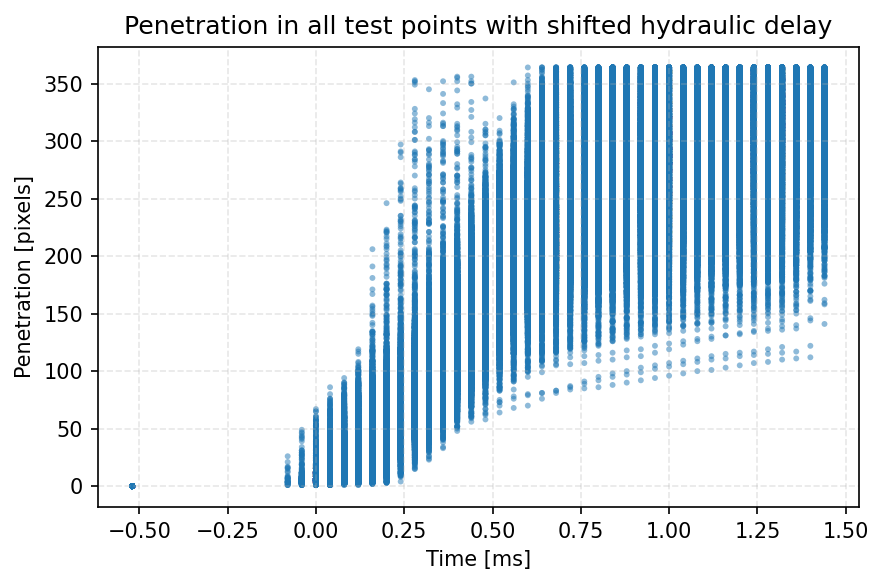

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.scatter(df_time_shifted["time_ms"], df_time_shifted["penetration_pixels"],
s=8, alpha=0.5, edgecolor="none")
ax.set_title("Penetration in all test points with shifted hydraulic delay")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Penetration [pixels]")
ax.grid(True, linestyle="--", alpha=0.3)
fig.tight_layout()

In [72]:
TARGET_COLUMN = "penetration_pixels"
IGNORED_COLUMNS = {"source_file", "is_right_censored"}
EXPECTED_FEATURE_COLUMNS = [
    "time_ms",
    "tilt_angle_radian",
    "plumes",
    "diameter_mm",
    "chamber_pressure",
    "injection_duration",
]
missing_features = [c for c in EXPECTED_FEATURE_COLUMNS if c not in raw_df.columns]
if missing_features:
    raise ValueError(f"Missing expected feature columns: {missing_features}")
FEATURE_COLUMNS = EXPECTED_FEATURE_COLUMNS
TIME_FEATURE = "time_ms"

print("Feature columns used for training:", FEATURE_COLUMNS)
print("Output features:", TARGET_COLUMN)


Feature columns used for training: ['time_ms', 'tilt_angle_radian', 'plumes', 'diameter_mm', 'chamber_pressure', 'injection_duration']
Output features: penetration_pixels


In [73]:
# Configuration
CONFIG = {
    "seed": 42,
    "data_dir": str(DATA_DIR),
    "target_column": TARGET_COLUMN,
    "feature_columns": FEATURE_COLUMNS,
    "time_feature": TIME_FEATURE,
    "splits": {"val": 0.15, "test": 0.15},
    "batch_size": 256,
    "hidden_dims": [256, 256, 64],
    "dropout": 0.05,
    "activation": "tanh", # "relu",
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "num_workers": 0,
    "pin_memory": torch.cuda.is_available(),
    "shuffle_train": True,
    "epochs": 50,
    "grad_clip_norm": 1.0,
    "log_interval": 50,
    "log_var_bounds": (-10.0, 6.0),
    "std_clamp_min": 1e-3,
    "runs_root": str(RUNS_ROOT.resolve()),
}
CONFIG["input_dim"] = len(CONFIG["feature_columns"])
CONFIG["output_dim"] = 2
CONFIG["device"] = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])


In [74]:
# MLP architecture

def make_activation(name: str) -> nn.Module:
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "gelu":
        return nn.GELU()
    if name == "tanh":
        return nn.Tanh()
    raise ValueError(f"Unsupported activation '{name}'")


class PenetrationMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: list[int],
        output_dim: int,
        *,
        activation: str = "relu",
        dropout: float = 0.0,
    ) -> None:
        super().__init__()
        layers: list[nn.Module] = []
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend(
                [
                    nn.Linear(in_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    make_activation(activation),
                ]
            )
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


model = PenetrationMLP(
    input_dim=CONFIG["input_dim"],
    hidden_dims=CONFIG["hidden_dims"],
    output_dim=CONFIG["output_dim"],
    activation=CONFIG["activation"],
    dropout=CONFIG["dropout"],
).to(CONFIG["device"])

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"Trainable parameters: {trainable_params:,}")

PenetrationMLP(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): Tanh()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (10): Tanh()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)
Trainable parameters: 85,314


In [75]:
class PenetrationDataset(Dataset):
    def __init__(
        self,
        features: np.ndarray,
        targets: np.ndarray,
        censor_flags: np.ndarray,
        censor_thresholds: np.ndarray,
    ) -> None:
        self.features = torch.as_tensor(features, dtype=torch.float32)
        self.targets = torch.as_tensor(targets, dtype=torch.float32)
        self.censor_flags = torch.as_tensor(censor_flags, dtype=torch.float32)
        self.censor_thresholds = torch.as_tensor(censor_thresholds, dtype=torch.float32)

    def __len__(self) -> int:
        return self.features.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        return (
            self.features[idx],
            self.targets[idx],
            self.censor_flags[idx],
            self.censor_thresholds[idx],
        )

Now, we code the data loader and split the data into training, validation and testing datasets.

In [76]:
def train_val_test_split(
    n_samples: int,
    val_ratio: float,
    test_ratio: float,
    *,
    seed: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not 0 < val_ratio < 1 or not 0 < test_ratio < 1:
        raise ValueError("Validation and test ratios must be in (0, 1).")
    if val_ratio + test_ratio >= 1:
        raise ValueError("Sum of validation and test ratios must be < 1.")

    rng = np.random.default_rng(seed)
    indices = np.arange(n_samples)
    rng.shuffle(indices)

    n_test = int(np.floor(test_ratio * n_samples))
    n_val = int(np.floor(val_ratio * n_samples))
    test_idx = indices[:n_test]
    val_idx = indices[n_test : n_test + n_val]
    train_idx = indices[n_test + n_val :]
    return train_idx, val_idx, test_idx


split_cfg = CONFIG["splits"]
train_idx, val_idx, test_idx = train_val_test_split(
    len(raw_df),
    split_cfg["val"],
    split_cfg["test"],
    seed=CONFIG["seed"],
)

feature_array = raw_df[FEATURE_COLUMNS].to_numpy(dtype=np.float32, copy=True)
target_array = raw_df[[TARGET_COLUMN]].to_numpy(dtype=np.float32, copy=True)
censor_array = raw_df[["is_right_censored"]].to_numpy(dtype=np.float32, copy=True)

x_scaler = Standardizer().fit(feature_array[train_idx])
y_scaler = Standardizer().fit(target_array[train_idx])

feature_scaled = x_scaler.transform(feature_array).astype(np.float32, copy=False)
target_scaled = y_scaler.transform(target_array).astype(np.float32, copy=False)

X_train = feature_scaled[train_idx]
X_val = feature_scaled[val_idx]
X_test = feature_scaled[test_idx]

y_train = target_scaled[train_idx]
y_val = target_scaled[val_idx]
y_test = target_scaled[test_idx]

censor_train = censor_array[train_idx]
censor_val = censor_array[val_idx]
censor_test = censor_array[test_idx]

threshold_train = target_scaled[train_idx]
threshold_val = target_scaled[val_idx]
threshold_test = target_scaled[test_idx]

train_dataset = PenetrationDataset(X_train, y_train, censor_train, threshold_train)
val_dataset = PenetrationDataset(X_val, y_val, censor_val, threshold_val)
test_dataset = PenetrationDataset(X_test, y_test, censor_test, threshold_test)




In [77]:

# Checking the size train_dataset.features.shape
print(train_dataset.features.shape)
print(val_dataset.features.shape)
print(test_dataset.features.shape)

torch.Size([204393, 6])
torch.Size([43798, 6])
torch.Size([43798, 6])


In [78]:
dataloader_kwargs = {
    "batch_size": CONFIG["batch_size"],
    "num_workers": CONFIG["num_workers"],
    "pin_memory": CONFIG["pin_memory"],
}

train_loader = DataLoader(train_dataset, shuffle=CONFIG["shuffle_train"], **dataloader_kwargs)
val_loader = DataLoader(val_dataset, shuffle=False, **dataloader_kwargs)
test_loader = DataLoader(test_dataset, shuffle=False, **dataloader_kwargs)

batch_features, batch_targets, batch_censored, batch_thresholds = next(iter(train_loader))
print(f"Train batch features shape: {batch_features.shape}")
print(f"Train batch targets shape: {batch_targets.shape}")
print(f"Train batch censor flags shape: {batch_censored.shape}")
print(f"Train batch censor thresholds shape: {batch_thresholds.shape}")

scalers_state = {"x": x_scaler.state_dict(), "y": y_scaler.state_dict()}
print("Saved scaler keys:", list(scalers_state.keys()))

Train batch features shape: torch.Size([256, 6])
Train batch targets shape: torch.Size([256, 1])
Train batch censor flags shape: torch.Size([256, 1])
Train batch censor thresholds shape: torch.Size([256, 1])
Saved scaler keys: ['x', 'y']
